Para la entrega de esta práctica, la tarea consiste en desarrollar un prototipo que procese uno (vídeo ejemplo proporcionado) o varios vídeos (incluyendo vídeos de cosecha propia):

detecte y siga las personas y vehículos presentes
detecte y lea las matrículas de los vehículos presentes
cuente el total de cada clase
vuelque a disco un vídeo que visualice los resultados
genere un archivo csv con el resultado de la detección y seguimiento. Se sugiere un formato con al menos los siguientes campos:

fotograma, tipo_objeto, confianza, identificador_tracking, x1, y1, x2, y2, matrícula_en_su_caso, confianza, mx1,my1,mx2,my2, texto_matricula

La entrega del cuaderno o cuadernos se hace efectiva a través del campus virtual por medio de un enlace github. Además del archivo README, debe incluirse el resultado del vídeo proporcionado como test (o enlace al mismo), y el correspondiente archivo csv. En el caso de entrenarse algún detector, por ejemplo de matrículas, debe proporcionarse acceso al conjunto de datos.

Se considerarán extras:

Determine el flujo de personas y vehículos en el vídeo de test en distintas direcciones (vehículos que dejan la imagen por la derecha, por la izquierda, etc.)

Evaluar dos alternativas para la detección de matrículas: basada en YOLO, y basada en contornos.

Anonimizar a las personas y vehículos presentes en un vídeo.

En el caso de haberse apuntado al Autumn Campus Makeathon InnovAction Canarias, se valorará la aplicación de habilidades adquiridas en esta práctica.


0: 384x640 1 car, 155.8ms
Speed: 5.0ms preprocess, 155.8ms inference, 8.0ms postprocess per image at shape (1, 3, 384, 640)

0: 352x640 1 pl_license_plate, 102.0ms


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Speed: 3.0ms preprocess, 102.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)
Matricula Detectada: 0269LKL


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


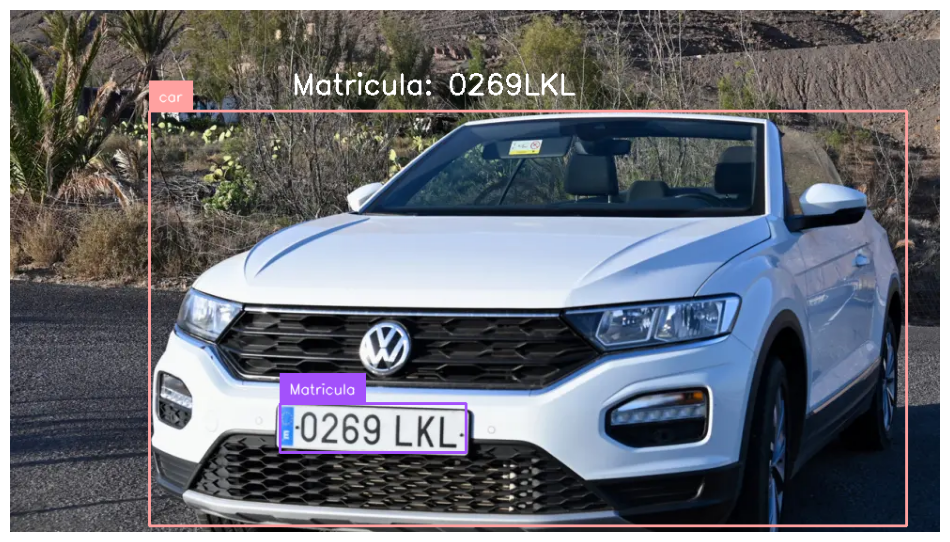

In [6]:
import cv2  
from ultralytics import YOLO
import pytesseract
import supervision as sv
from supervision.draw.color import ColorPalette
import numpy as np
import torch


# Se carga el modelo de Yolo11
model_person_and_car = YOLO('yolo11n.pt').to('cpu')

# Se lee la imagen que vamos a utilizar de prueba.
image = cv2.imread("cochematricula.webp")

# Funcion utilizada para devolver la imagen de la caja delimitadora del objeto detectado 
def cropped(detections, image):
    bounding_box = detections.xyxy
    xmin, ymin, xmax, ymax = bounding_box[0]
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    return image[ymin:ymax, xmin:xmax]


# Recogeremos el primer resultado del modelo de personas y coches de Yolo11
result = model_person_and_car(image)[0]

# Nos permite manejar las detecciones de forma mas sencilla
detections_t = sv.Detections.from_ultralytics(result)

# Clase de interes 2 porque, 2 = Car
class_id_of_interest = [2]


mask = [class_id in class_id_of_interest for class_id in detections_t.class_id]
if any(mask):

    # Inicializamos las etiquetas
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Se pasa la informacion que se mostrara en las etiquetas
    annotated_image_t = bounding_box_annotator.annotate(scene=image, detections=detections_t)
    annotated_image_t = label_annotator.annotate(scene=annotated_image_t, detections=detections_t)

    # Aplicamos la funcion comentada anteriormente para tener una imagen mas directa de car detectado
    cropped_image_t = cropped(detections_t, image)

    # Aplicamos ahora el modelo especializado en matriculas de coches.
    model_p = YOLO('placa.pt').to('cpu')

    # Modificamos el nombre que trae por defecto el modelo a "Matricula"
    results_p = model_p(cropped_image_t, agnostic_nms = True)[0]
    results_p.names[0] = "Matricula"

    detections_p = sv.Detections.from_ultralytics(results_p)

    # Aplicamos la funcion comentada anteriormente para tener una imagen mas directa de la matricula
    cropped_image_matricula = cropped(detections_p, cropped_image_t)

    # Extraemos las coordenadas de la matricula y realizamos una diferencia para pasarlas a la imagen original
    dif_x = results_p.boxes.xyxy[0][2] - results_p.boxes.xyxy[0][0]
    dif_y = results_p.boxes.xyxy[0][3] - results_p.boxes.xyxy[0][1]

    # Puntos iniciales, suma del punto de deteccion de la matricula mas el del coche
    x1_nuevo = detections_t.xyxy[0][0] + detections_p.xyxy[0][0]
    y1_nuevo = detections_t.xyxy[0][1] + detections_p.xyxy[0][1]

    # Puntos finales, suma del pueto inicial mas las dimensiones de la box de matricula
    x2_nuevo = x1_nuevo + dif_x  
    y2_nuevo = y1_nuevo + dif_y 

    # Guardamos las coordenadas
    detections_p.xyxy = np.array([[x1_nuevo,y1_nuevo,x2_nuevo,y2_nuevo]])

    # Inicializamos las etiquetas de la matricula
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Se pasa la informacion que se mostrara en las etiquetas
    annotated_image_p = bounding_box_annotator.annotate(scene=image, detections=detections_p)
    annotated_image_p = label_annotator.annotate(scene=annotated_image_p, detections=detections_p)

    # Pasamos la imagen a gris y con el OCR, detectamos las letras de la matricula y las mostraremos por pantalla
    gray = cv2.cvtColor(cropped_image_matricula, cv2.COLOR_BGR2GRAY)
    data = pytesseract.image_to_string(gray, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYXabcdefghijklmnopqrstuvwxyz')

    # Limpieza de la cadena de salida del OCR
    valor_medio = round(len(data)/2)
    data = data[valor_medio-3:valor_medio+4]
    print("Matricula Detectada:",data)
    text = "Matricula: "+data

    # Defininimos la posicion del texto, fuente, tamaño, color y grosor de este
    position = (300, 90)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (255, 255, 255)
    font_thickness = 2

    #Añadimos el texto a la imagen
    annotated_image_p = cv2.putText(annotated_image_p, text, position, font, font_scale, font_color, font_thickness)
        
#Mostramos por consola la imagen resultante
sv.plot_image(annotated_image_p)
       



In [8]:
import cv2
import torch
from ultralytics import YOLO
import pytesseract
import supervision as sv
import numpy as np
import csv
import os
import warnings

# Eliminamos los posibles warning que salgan por consola.
warnings.filterwarnings("ignore")

# Configuración de CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando el dispositivo: {device}")

# Cargar modelos y usamos el device detectado preferiblemente CUDA
model_person_and_car = YOLO('yolo11n.pt').to(device)
model_p = YOLO('placa.pt').to(device)

# Inicializamos captura de video
cap = cv2.VideoCapture('videoprueba.mp4')

# Configuración para guardar el video de salida
output_video_path = os.path.join(os.getcwd(), 'output_video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS), 
                      (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

# Archivo CSV para registrar las detecciones
csv_file_path = os.path.join(os.getcwd(), 'detections.csv')
with open(csv_file_path, mode='w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow([
        'Frame', 'Object_Type', 'Confidence', 'Tracking_ID', 'x1', 'y1', 'x2', 'y2', 
        'License_Plate_Detected', 'Plate_Confidence', 'mx1', 'my1', 'mx2', 'my2', 'Plate_Text'
    ])

# Contadores de detección
total_personas = 0
total_coches = 0
total_matriculas = 0

# Función para recortar la imagen según la detección
def cropped(detections, image):
    if detections.xyxy.shape[0] > 0:
        xmin, ymin, xmax, ymax = map(int, detections.xyxy[0])
        return image[ymin:ymax, xmin:xmax]
    return None

# Contador de frames para en el CSV establecer en que frame se detecto dicha detección
frame_number = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_number += 1
    # Detección de personas y autos en el frame original
    result = model_person_and_car(frame, verbose=False)[0]
    detections_t = sv.Detections.from_ultralytics(result)
    
    # Por cada detección recogemos la clase, la confianza, el id de seguimiento y sus coordenadas
    for detection in detections_t:
        if detection is None or len(detection) < 5:
            continue

        obj_class = detection[5]['class_name'] # Clase
        confidence = detection[2]  # Confianza
        tracking_id = detection[3]  # ID de seguimiento
        bbox = detection[0] # Coordenadas
        
        # Definimos el tipo de clase detectada y si es aumentamos en 1 el contador de dicha clase (Persona o Coche)
        if obj_class == 'person':  # Persona
            obj_type = 'Person'
            total_personas += 1
        elif obj_class == 'car':  # Coche
            obj_type = 'Car'
            total_coches += 1
        else:
            continue  # Ignorar otras clases

        # Guardamos la detección en el CSV
        with open(csv_file_path, mode='a', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)
            csv_writer.writerow([
            frame_number, obj_type, confidence, tracking_id, bbox[0], bbox[1], bbox[2], bbox[3], '', '', '', '', '', ''
            ])
    
    # Procesar matrículas en las detecciones de coches
    class_id_of_interest = [2]  # Solo coches
    mask = [class_id in class_id_of_interest for class_id in detections_t.class_id]
    
    # Registramos ahora las etiquetas
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # Anotar todas las detecciones en el frame
    annotated_frame = bounding_box_annotator.annotate(scene=frame, detections=detections_t)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_t)

    if any(mask):
        # Recortar el área del coche y verificar que el recorte no sea None
        cropped_image_t = cropped(detections_t, frame)
        if cropped_image_t is not None:

            # Una vez tengamos la imagen resultante le aplicamos un resize con la mayor resolucion posible para trabajar con CUDA
            cropped_image_resized = cv2.resize(cropped_image_t, (832, 512))
            results_p = model_p(cropped_image_resized, verbose=False)[0] #Aplicamos el modelo y tomamos solo el primer resultado
            detections_p = sv.Detections.from_ultralytics(results_p)

            # Nos aseguramos de que las coordenadas de la caja delimitadora sean superiores a 0 de la primera detección
            if detections_p.xyxy.shape[0] > 0:

                # Ahora por cada detection en detections_p tomaremos sus coordenadas y confianza
                for detection in detections_p:
                    total_matriculas += 1 # Aumentamos el contador de matricula
                    plate_bbox = detection[0] # Coordendas de la matricula
                    plate_confidence = detection[2] # Confianza de la matricula
                    px1, py1, px2, py2 = map(int, plate_bbox) # Dividimos las coordenadas en 4 variables
                cropped_image_matricula = cropped(detections_p, cropped_image_resized)
                
                # Si a la hora de recoger la imagen resultante de la caja delimitadora de la matricula no da fallo entramos en el condicional
                if cropped_image_matricula is not None:

                    # Misma logica que en el anterior codigo, pasamos a gris y aplicamos OCR detectando las letras de la matricula
                    gray = cv2.cvtColor(cropped_image_matricula, cv2.COLOR_BGR2GRAY)
                    data = pytesseract.image_to_string(
                        gray, lang='eng', config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
                    )

                    # Limpieza del texto de la matrícula
                    data = data.strip()[:7]  # Solo primeros 7 caracteres

                    # Colocar el texto en el frame
                    position = (int(detections_t.xyxy[0][0]), int(detections_t.xyxy[0][1]) - 10)
                    annotated_frame = cv2.putText(annotated_frame, f"Matricula: {data}", position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

                    # Guardar en el CSV
                    with open(csv_file_path, mode='a', newline='') as csv_file:
                        csv_writer = csv.writer(csv_file)
                        csv_writer.writerow([
                            frame_number, 'License Plate', confidence, tracking_id, bbox[0], bbox[1], bbox[2], bbox[3],
                            'Yes', plate_confidence, px1, py1, px2, py2, data
                        ])

    # Escribir el frame anotado en el video de salida
    out.write(annotated_frame)
    cv2.imshow('Video', annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Resumen en consola
print(f"Conteo total de personas: {total_personas}")
print(f"Conteo total de coches: {total_coches}")
print(f"Conteo total de matrículas: {total_matriculas}")
print(f"Video guardado en: {output_video_path}")
print(f"CSV de detecciones guardado en: {csv_file_path}")

cap.release()
out.release()
cv2.destroyAllWindows()

Usando el dispositivo: cuda
Conteo total de personas: 265
Conteo total de coches: 2437
Conteo total de matrículas: 16
Video guardado en: c:\Users\ADMIN\anaconda3\envs\Antonio_P1\output_video.mp4
CSV de detecciones guardado en: c:\Users\ADMIN\anaconda3\envs\Antonio_P1\detections.csv
